This project applying some famous financial risk measurement methods to any inputed stock name from Tehran's stock market and build efficient portfolio.

### Import libraries

In [60]:
import pytse_client as tse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from seaborn import heatmap
import cvxpy as cp
from scipy.optimize import minimize

### Fetching data from TSETMC

In [61]:
def get_symbol(symbols,symbol_en,cut_off_date=dt(2021,1,1)):
    symbols_data = tse.download(symbols=symbols, write_to_csv=False, adjust=True, include_jdate=True)
    for symbol in symbols:
        df = symbols_data[symbol].copy()
        df = df[(df.date>cut_off_date) & (df.date<dt.now().replace(day=1))].iloc[:-1]
        df['return'] = round((df.adjClose-df.yesterday)*100/df.yesterday,1)
        df = df.iloc[1:]
        symbols_data[symbol] = df
    symbols_daily = symbols_data
    symbols_monthly = pd.DataFrame()
    for symbol in symbols:
        df = symbols_data[symbol].copy()
        month = df.date.apply(lambda x: int(str(x).split()[0].replace('-',''))//100)
        df['month'] = month
        df = df.drop_duplicates('month',keep='first').reset_index(drop=True)
        curr_month = df.adjClose[1:].reset_index(drop=True)
        prev_month = df.adjClose[:-1].reset_index(drop=True)
        monthly_return = np.round((100*(curr_month-prev_month)/prev_month),1)
        df = df.iloc[1:].reset_index(drop=True)
        df[symbol] = monthly_return
        df = df.loc[:,['month',symbol]].set_index('month')
        symbols_monthly = pd.concat([symbols_monthly,df],axis=1)
    symbols_monthly = symbols_monthly.reset_index()
    symbols_monthly['month'] = symbols_monthly.month.astype(str)
    symbols_monthly = symbols_monthly.set_index('month')
    symbols_monthly.columns = symbol_en
    symbols_monthly = symbols_monthly.fillna(symbols_monthly.mean())
    return symbols_daily,symbols_monthly

In [62]:
symbols = ['برکت','فولاد','وبملت','خزامیا','زملارد','کرمان','اخابر','ورنا','حکشتی','سبزوا','شپنا',
           'دانا','غگلستا','کحافظ','خودرو','کگل','اوان','پلاسک','گدنا']
symbol_en = ['Barkat','Folad','VBmellat','KHzamia','Zemalard','Kerman','Akhaber','Varna',
            'Hkeshti','Sabzeva','Shapna','Dana','GHgolsta','Khafez','Khodro','Kgol',
            'Evan','Pelask','Gadna']
symbols_daily,symbols_monthly = get_symbol(symbols,symbol_en)

## First approach for portfolio selection

### Return-Variance graph

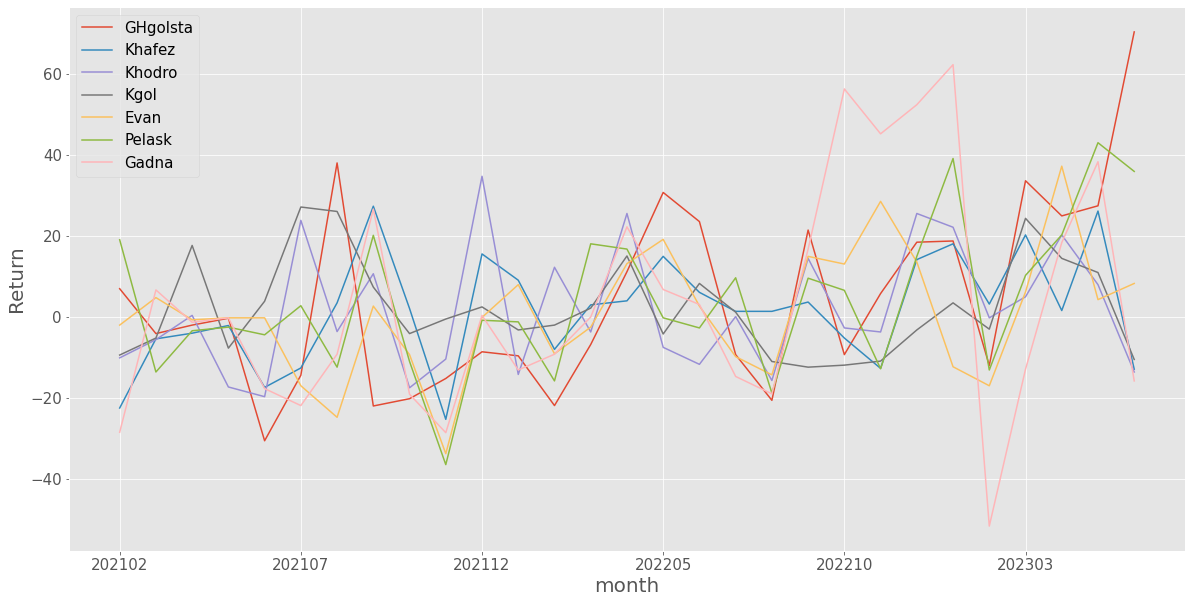

In [63]:
ax = symbols_monthly.iloc[:,12:].plot(figsize=(20,10),ylabel='Return',fontsize=15)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.legend(fontsize=15)

,Barkat,Folad,VBmellat,KHzamia,Zemalard,Kerman,Akhaber,Varna,Hkeshti,Sabzeva,Shapna,Dana,GHgolsta,Khafez,Khodro,Kgol,Evan,Pelask,Gadna
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,1.644828,3.465517,2.951724,6.603448,3.182759,0.465517,1.641379,3.451724,4.496552,2.979310,4.410345,5.687500,4.313793,1.648276,1.593103,2.268966,0.824138,4.055172,3.217241
std,20.125598,11.605026,12.377965,20.172214,21.753687,16.683509,18.409480,21.209981,15.579920,19.375157,12.358032,19.360846,23.139155,13.411579,15.351313,11.636768,15.246631,18.277593,27.893869
min,-26.300000,-13.400000,-18.300000,-37.500000,-30.000000,-26.500000,-27.700000,-26.400000,-25.300000,-39.200000,-22.900000,-38.700000,-30.600000,-25.300000,-19.700000,-12.400000,-33.800000,-36.500000,-51.700000
25%,-10.300000,-6.400000,-7.400000,-6.000000,-13.600000,-9.900000,-8.400000,-9.900000,-4.700000,-10.200000,-2.500000,-0.500000,-12.000000,-5.400000,-10.400000,-5.200000,-9.300000,-11.000000,-15.800000
50%,-2.800000,2.600000,4.000000,8.500000,0.700000,-4.800000,-1.200000,-2.000000,5.900000,-2.500000,4.200000,5.687500,-2.000000,2.100000,-2.700000,-0.500000,-0.100000,-0.200000,-0.200000
75%,7.700000,9.400000,10.800000,18.700000,14.500000,10.400000,7.500000,18.800000,14.500000,15.100000,14.700000,18.700000,21.500000,9.100000,12.300000,8.300000,8.300000,16.800000,18.400000
max,56.000000,39.400000,24.400000,42.500000,57.800000,45.100000,64.300000,56.500000,41.200000,61.400000,26.200000,37.900000,70.500000,27.400000,34.800000,27.200000,37.300000,43.100000,62.400000


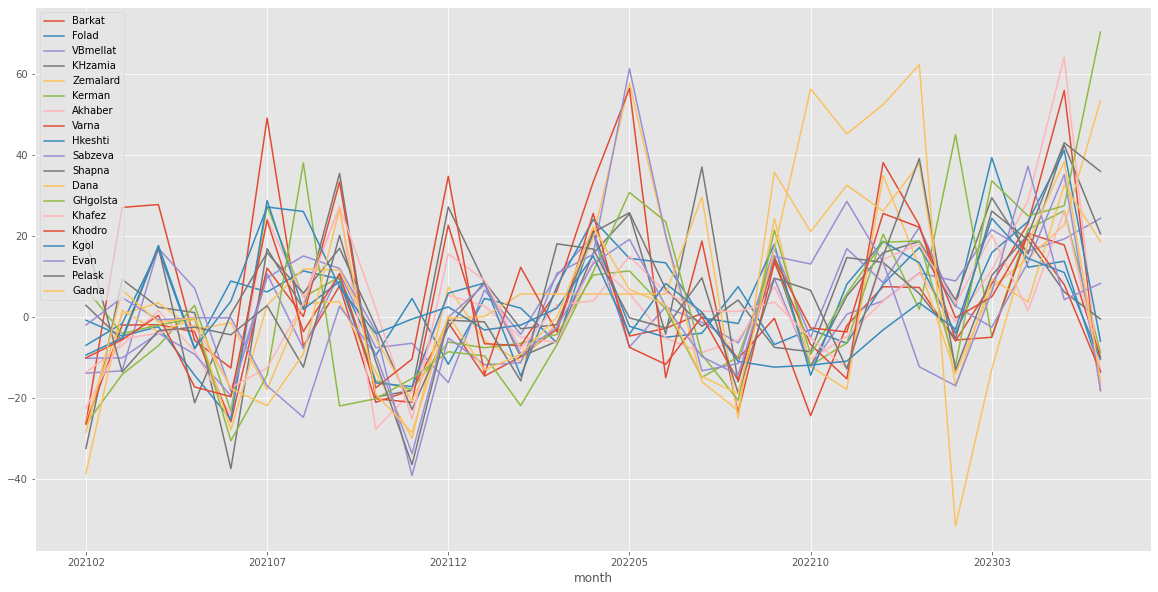

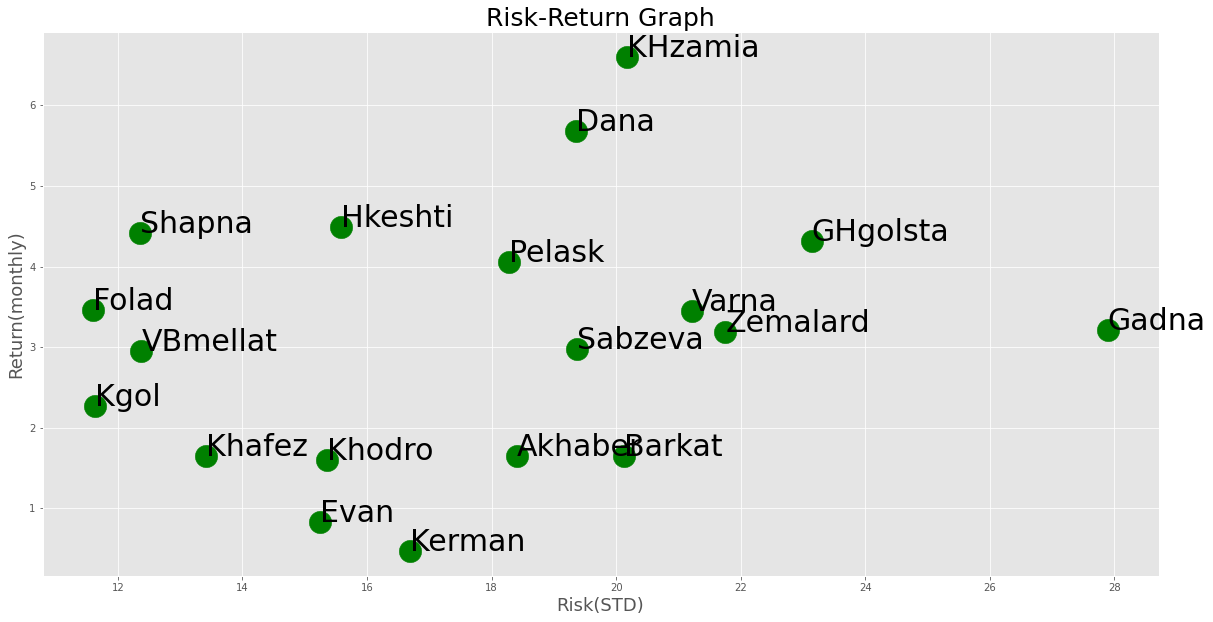

In [64]:
def plot_mean_var(symbols_desc,period='daily'):
    plt.style.use('ggplot')
    plt.figure(figsize=(20,10))
    plt.title("Risk-Return Graph", fontsize=25)
    plt.xlabel('Risk(STD)', fontsize=18)
    plt.ylabel(f'Return({period})', fontsize=18)
    for _,df in symbols_desc.iterrows():
        plt.scatter(df.return_std,df.return_mean,s=500, c='g')
        plt.text(df.return_std,df.return_mean,df.symbol_en,size=30)
    plt.show()
display(symbols_monthly.describe())
symbols_monthly.plot(figsize=(20,10))
df = pd.concat([symbols_monthly.mean(),symbols_monthly.std()],axis=1).reset_index()
df.columns = ['symbol_en','return_mean','return_std']
plot_mean_var(df,period='monthly')

### Correlation

,Barkat,Folad,VBmellat,KHzamia,Zemalard,Kerman,Akhaber,Varna,Hkeshti,Sabzeva,Shapna,Dana,GHgolsta,Khafez,Khodro,Kgol,Evan,Pelask,Gadna
Barkat,1.00,0.46,0.50,0.59,0.21,0.55,0.79,0.47,0.71,0.41,0.43,0.33,0.13,0.35,0.54,0.60,0.15,0.34,0.28
Folad,0.46,1.00,0.43,0.24,0.05,0.23,0.48,0.19,0.37,0.13,0.56,0.04,0.11,0.36,0.31,0.69,-0.03,0.16,0.14
VBmellat,0.50,0.43,1.00,0.56,0.40,0.52,0.53,0.30,0.57,0.26,0.39,0.41,0.48,0.35,0.30,0.38,0.25,0.56,0.16
KHzamia,0.59,0.24,0.56,1.00,0.52,0.52,0.70,0.75,0.68,0.48,0.41,0.68,0.43,0.70,0.55,0.31,0.29,0.51,0.35
Zemalard,0.21,0.05,0.40,0.52,1.00,0.35,0.31,0.61,0.43,0.57,0.39,0.45,0.74,0.47,0.23,0.06,0.51,0.53,0.37
Kerman,0.55,0.23,0.52,0.52,0.35,1.00,0.68,0.55,0.64,0.59,0.30,0.31,0.24,0.46,0.51,0.31,0.14,0.26,0.16
Akhaber,0.79,0.48,0.53,0.70,0.31,0.68,1.00,0.59,0.85,0.60,0.49,0.42,0.27,0.63,0.60,0.51,0.25,0.52,0.40
Varna,0.47,0.19,0.30,0.75,0.61,0.55,0.59,1.00,0.62,0.67,0.46,0.52,0.27,0.65,0.67,0.24,0.35,0.46,0.49
Hkeshti,0.71,0.37,0.57,0.68,0.43,0.64,0.85,0.62,1.00,0.70,0.63,0.48,0.45,0.57,0.61,0.44,0.38,0.56,0.41
Sabzeva,0.41,0.13,0.26,0.48,0.57,0.59,0.60,0.67,0.70,1.00,0.58,0.47,0.42,0.59,0.33,0.22,0.42,0.40,0.48


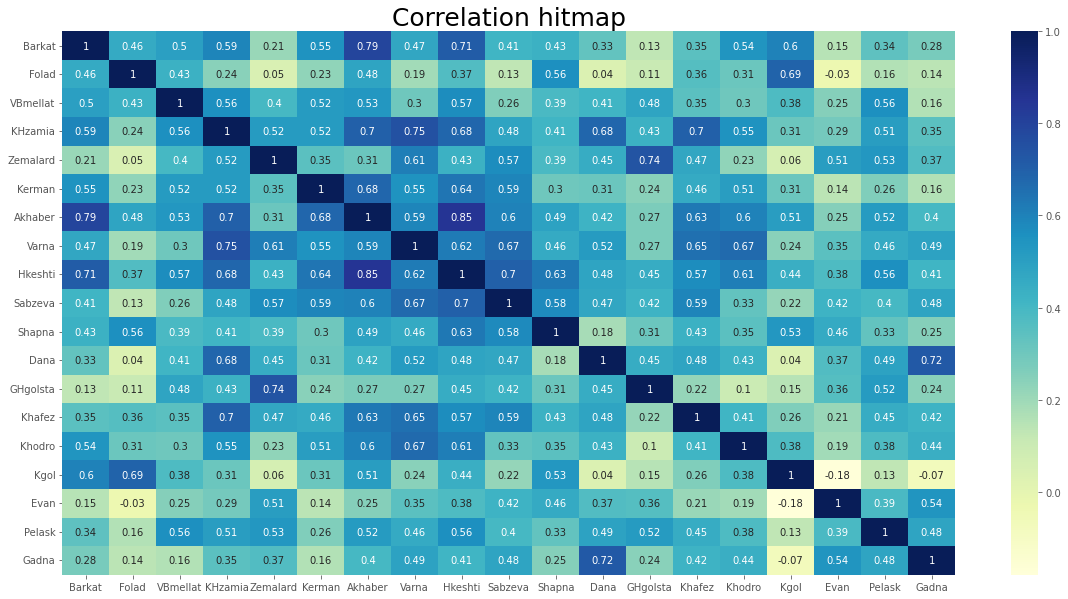

In [65]:
corr_mat = np.round(symbols_monthly.corr(),2)
display(corr_mat)
plt.figure(figsize=(20,10))
hm = heatmap(corr_mat, cmap="YlGnBu", annot=True)
plt.title("Correlation hitmap", fontsize=25)
pass

### Markovitz mean-variance approach
We are going to use cvxpy library for optimizing W'.Σ.W. This optimizing can make us the best portfolio with inputed conditions on W and expected return.

In [66]:
def optimize_portfolio(returns, target_ret=None, short_sell=False):
    returns = returns.T.to_numpy()
    n, m = returns.shape
    weights = cp.Variable(n)
    sum_weights = cp.sum(weights)
    mu = returns.mean(axis=1)
    
    if target_ret is not None:
        target_return = cp.Parameter()
        target_return.value = target_ret
    
    cov_matrix = np.cov(returns)
    risk = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(risk)
    
    limit_return = [weights.T@mu >= target_return] if target_ret is not None else []
    short_avail = [weights >= 0] if not short_sell else []
    
    constraints = [sum_weights == 1]+short_avail+limit_return
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)
    
    Er = weights.value@mu
    
    return np.round(weights.value,2), np.sqrt(risk.value), np.round(Er,2)

In [67]:
def pie_weight(weights,risk=None,Er=None,title=""):
    weights_per = np.array(weights*100).astype(int)
    y ,mylabels = [],[]
    neg_flag = False
    for i in range(len(symbol_en)):
        if weights_per[i]:
            if weights_per[i]<0:
                neg_flag=True
            y.append(weights_per[i])
            mylabels.append(symbol_en[i])
    plt.figure(figsize=(7,7))
    if risk is not None:
        plt.title(f'Expected return:{np.round(Er,1)}%, Risk:{np.round(risk,1)}%')
    else:
        plt.title(title)
    if neg_flag:
        plt.ylabel(f'Weight', fontsize=18)
        pd.Series(weights,index=symbol_en).plot(kind='bar')
    else:
        plt.pie(y, labels = mylabels,autopct='%1.0f%%')
    plt.show()

Let's optimize our portfolio risk with no special expected return

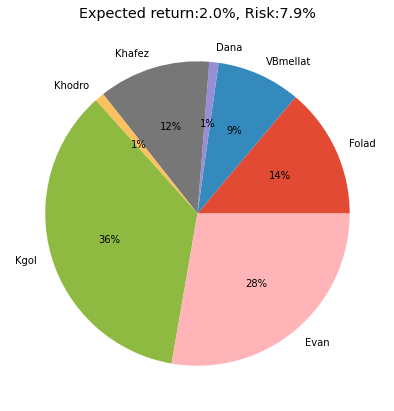

In [69]:
weights, risk, Er = optimize_portfolio(symbols_monthly,short_sell=False)
pie_weight(weights, risk, Er)

Now assume that we have short sell

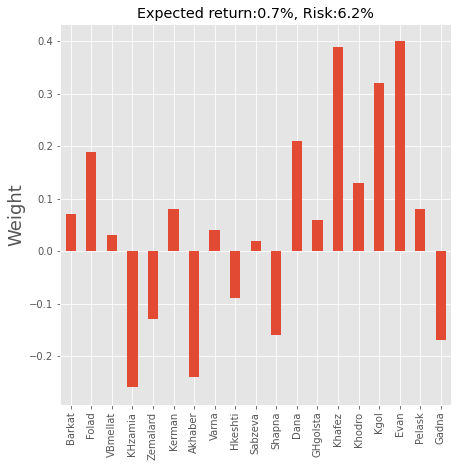

In [70]:
weights, risk, Er = optimize_portfolio(symbols_monthly,short_sell=True)
pie_weight(weights, risk, Er)

What if we want 4% return

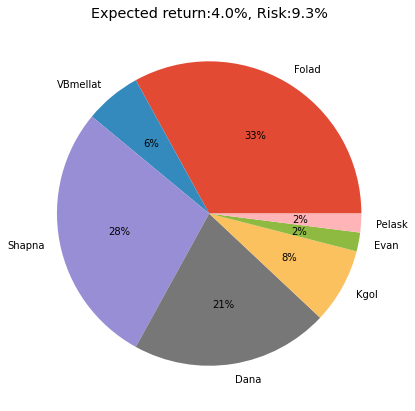

In [46]:
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=False)
pie_weight(weights, risk, Er)

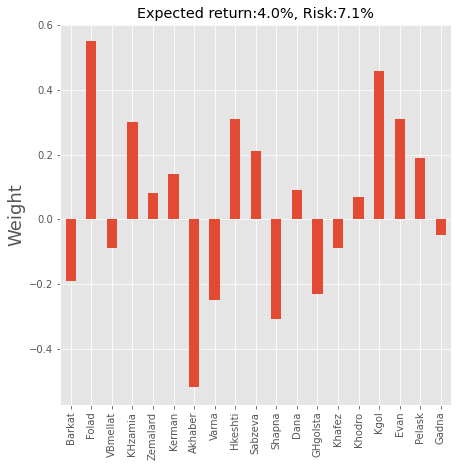

In [47]:
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=True)
pie_weight(weights, risk, Er)

### Plot efficient frontier

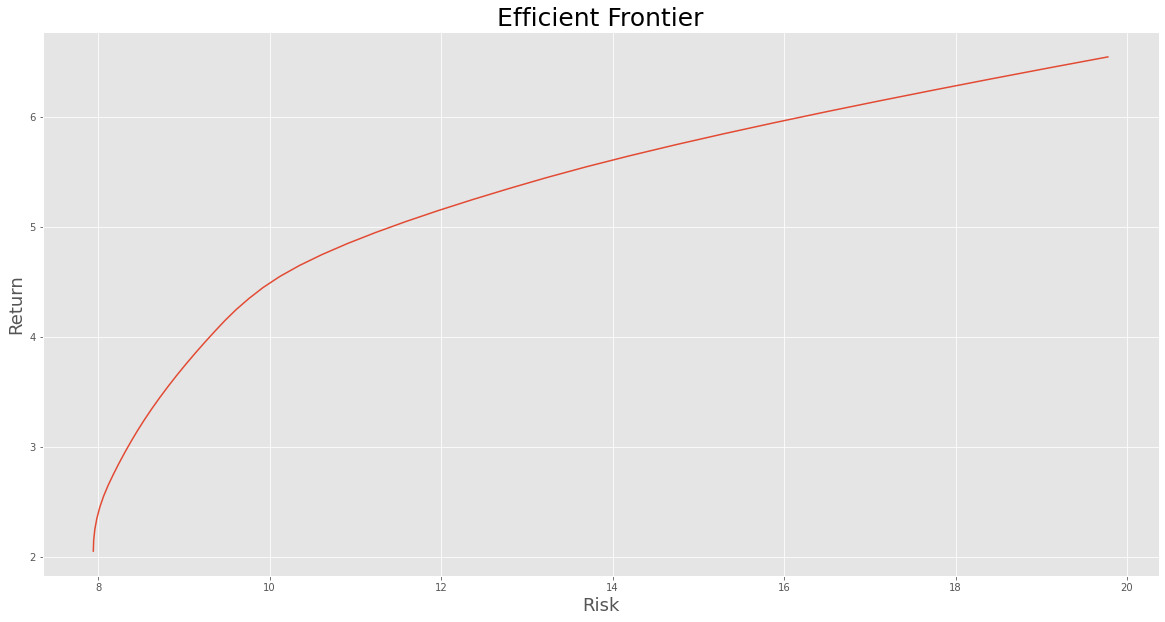

In [71]:
eff_front = {'weight':[],'risk':[],'Er':[]}
weights, risk, Er = optimize_portfolio(symbols_monthly)
for ret in np.arange(Er,max(symbols_monthly.mean()),0.1):
    weights, risk, Er = optimize_portfolio(symbols_monthly,ret)
    eff_front['weight'].append(weights)
    eff_front['risk'].append(risk)
    eff_front['Er'].append(Er)
eff_front = pd.DataFrame(eff_front)
plt.figure(figsize=(20,10))
plt.plot(eff_front.risk,eff_front.Er)
plt.title("Efficient Frontier", fontsize=25)
plt.xlabel('Risk', fontsize=18)
plt.ylabel(f'Return', fontsize=18)
pass

### Let's add ETF, Gold and non-risk assets

In [72]:
symbols += ['اطلس','طلا','افران']
symbol_en += ['ETF','Gold','Non-Risk']
symbols_daily,symbols_monthly = get_symbol(symbols,symbol_en)

,ETF,Gold,Non-Risk
count,29.000000,29.000000,29.000000
mean,2.868966,3.489655,1.779310
std,8.609053,8.956735,0.198889
min,-11.700000,-16.700000,1.500000
25%,-3.500000,-2.600000,1.700000
50%,0.300000,3.200000,1.800000
75%,10.900000,9.500000,1.800000
max,20.600000,24.100000,2.400000


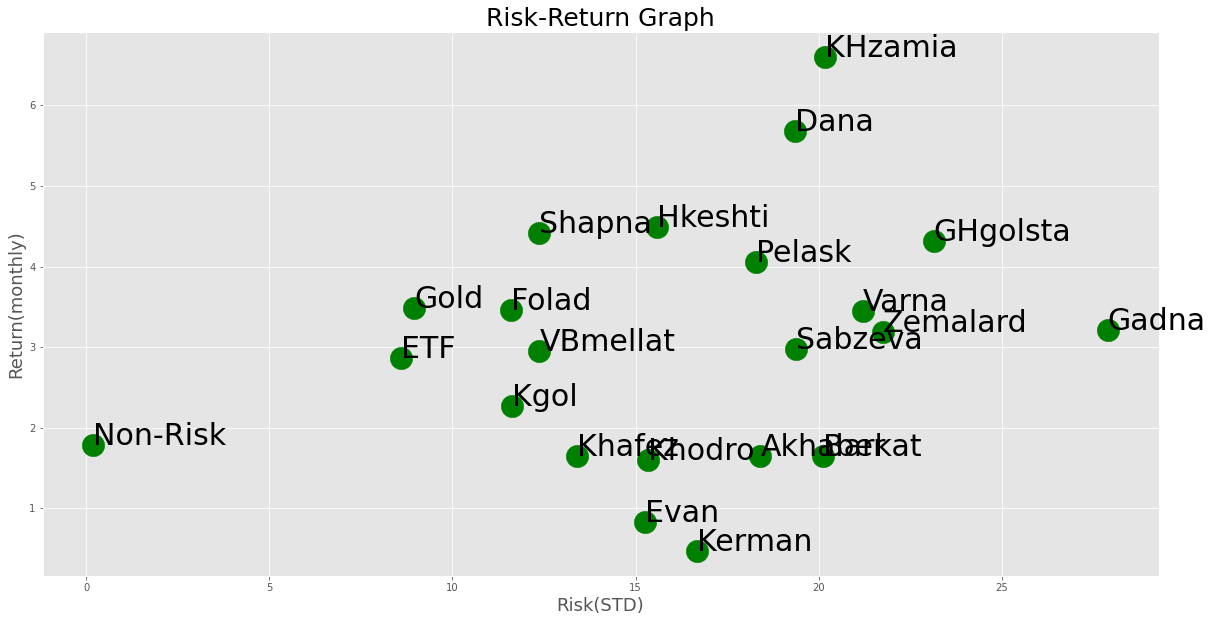

In [73]:
display(symbols_monthly[['ETF','Gold','Non-Risk']].describe())
df = pd.concat([symbols_monthly.mean(),symbols_monthly.std()],axis=1).reset_index()
df.columns = ['symbol_en','return_mean','return_std']
plot_mean_var(df,period='monthly')

So these are assets with lower risk

Minimize risk and all of our portfo will fill with non-risk asset:

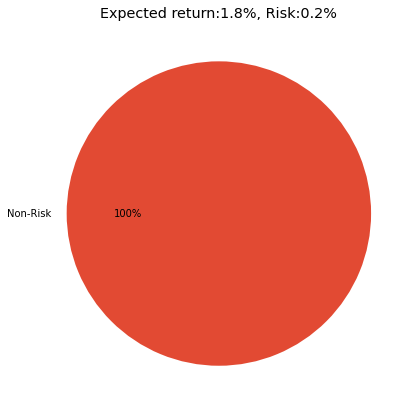

In [51]:
weights, risk, Er = optimize_portfolio(symbols_monthly,short_sell=False)
pie_weight(weights, risk, Er)

Compare risk of 4% profit with senario that we don't have Gold and non-risk asset

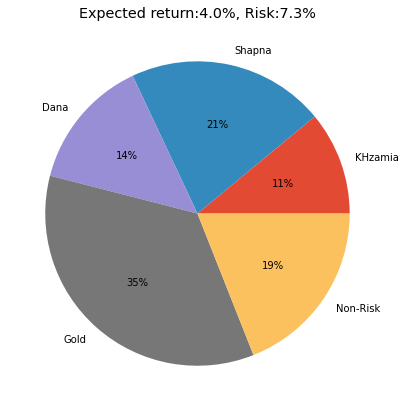

In [52]:
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=False)
pie_weight(weights, risk, Er)

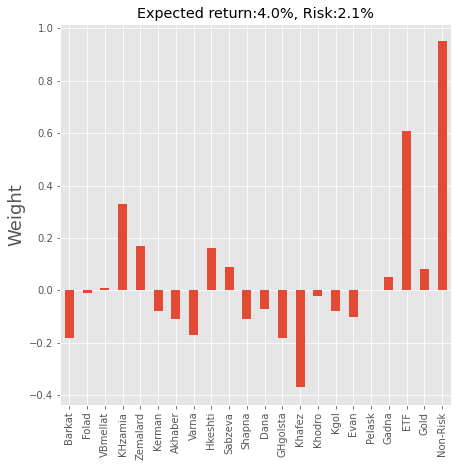

In [53]:
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=True)
pie_weight(weights, risk, Er)

In [54]:
eff_front2 = {'weight':[],'risk':[],'Er':[]}
weights, risk, Er = optimize_portfolio(symbols_monthly)
for ret in np.arange(Er,max(symbols_monthly.mean()),0.1):
    weights, risk, Er = optimize_portfolio(symbols_monthly,ret)
    eff_front2['weight'].append(weights)
    eff_front2['risk'].append(risk)
    eff_front2['Er'].append(Er)
eff_front2 = pd.DataFrame(eff_front2)

In [55]:
eff_front3 = {'weight':[],'risk':[],'Er':[]}
weights, risk, Er = optimize_portfolio(symbols_monthly)
for ret in np.arange(Er,max(symbols_monthly.mean()),0.1):
    weights, risk, Er = optimize_portfolio(symbols_monthly,ret,short_sell=True)
    eff_front3['weight'].append(weights)
    eff_front3['risk'].append(risk)
    eff_front3['Er'].append(Er)
eff_front3 = pd.DataFrame(eff_front3)

we got better efficient frontier with non-risk and gold asset! for same risk we can have more return

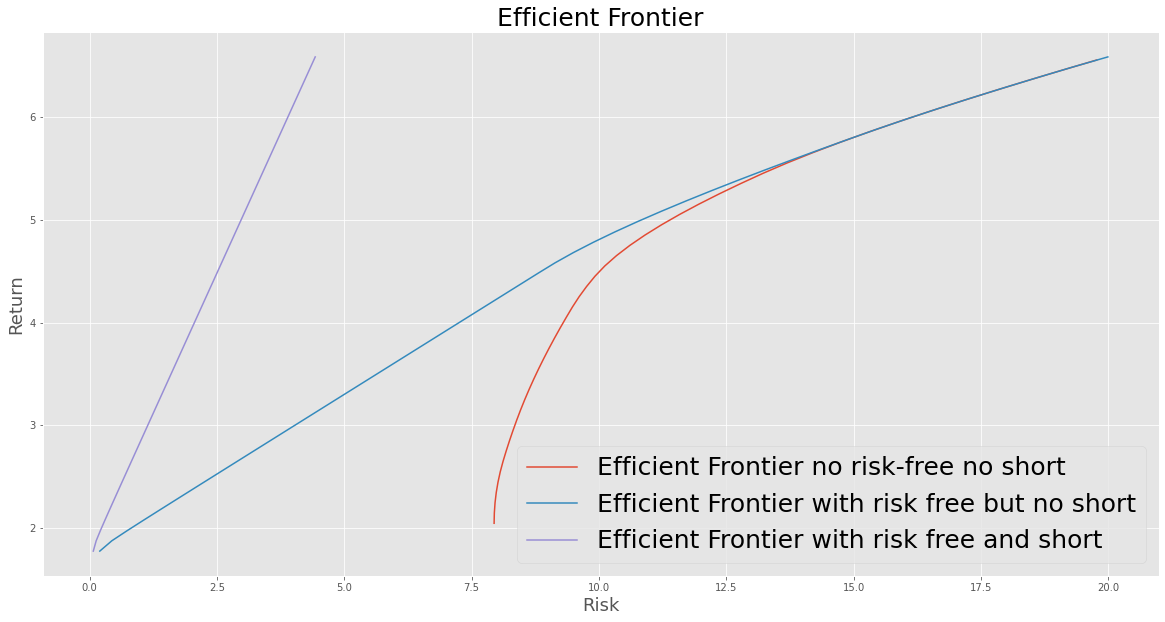

In [59]:
plt.figure(figsize=(20,10))
plt.plot(eff_front.risk, eff_front.Er, label='Efficient Frontier no risk-free no short')
plt.plot(eff_front2.risk, eff_front2.Er, label='Efficient Frontier with risk free but no short')
plt.plot(eff_front3.risk, eff_front3.Er, label='Efficient Frontier with risk free and short')
plt.legend(fontsize=25)
plt.title("Efficient Frontier", fontsize=25)
plt.xlabel('Risk', fontsize=18)
plt.ylabel(f'Return', fontsize=18)
plt.show()

## Second Approach for portfolio selection

In [19]:
from scipy.stats import norm

def reverse_f(r, e, p, teta=0.25):
    """
    Calculate the reverse of the function f(x) = P(|Rx - rx| <= 0.25) for a given probability value p.
    
    Parameters:
    r (float): Mean of the normal distribution.
    e (float): Standard deviation of the normal distribution.
    p (float): Probability value, between 0 and 1.
    
    Returns:
    x (float): The value of x for which f(x) = p.
    """
    # Calculate the standard deviation of the absolute value of Rx-rx
    std_abs = e * (2 / (2 * norm.cdf(teta / e) - 1)) 
    
    # Calculate the mean of |Rx-rx|
    mean_abs = abs(r - r)
    
    # Calculate the z-score corresponding to the given probability value
    z = norm.ppf(p)
    
    # Calculate the value of |Rx-rx| corresponding to the z-score
    abs_rx_rx = mean_abs + z * std_abs
    
    # Calculate the value of x for which |Rx-rx| = abs_rx_rx
    x = (abs_rx_rx + r) / norm.pdf(0)
    
    return x

In [ ]:
from scipy.stats import norm

def reverse_f(r, e, p, teta=0.25):
    std_abs = e * (2 / (2 * norm.cdf(teta / e) - 1)) 
    z = norm.ppf(p)
    abs_rx_rx = z * std_abs
    x = (abs_rx_rx + r) / norm.pdf(0)
    
    return x

In [20]:
df = symbols_monthly.describe().T.loc[:,['mean','std']].sort_values(by='mean', ascending=False)
a = dict()
for name,value in df.iterrows():
    a[name] = {y:reverse_f(value['mean']/100, value['std']/100, y)
               for y in np.arange(0.05,1,0.05)}
df = pd.DataFrame(a)
df = df[df>0].dropna().T
df

,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
KHzamia,0.165524,0.327455,0.491994,0.662059,0.841281,1.034691,1.250061,1.501101,1.816968,2.285129
Dana,0.142564,0.294381,0.448644,0.608087,0.776116,0.957445,1.159364,1.394725,1.690863,2.129784
Hkeshti,0.112712,0.222816,0.334693,0.450328,0.572189,0.703696,0.850136,1.020829,1.235600,1.553924
Shapna,0.110551,0.191908,0.274575,0.360018,0.450063,0.547235,0.655440,0.781567,0.940264,1.175476
GHgolsta,0.108131,0.310577,0.516285,0.728900,0.952964,1.194765,1.464021,1.777873,2.172769,2.758066
Pelask,0.101648,0.240606,0.381803,0.527740,0.681537,0.847507,1.032324,1.247749,1.518804,1.920548
Gold,0.087473,0.144196,0.201832,0.261404,0.324184,0.391934,0.467376,0.555313,0.665958,0.829951
Folad,0.086868,0.162332,0.239013,0.318268,0.401791,0.491925,0.592294,0.709287,0.856490,1.074667
Varna,0.086522,0.261992,0.440290,0.624574,0.818783,1.028364,1.261742,1.533773,1.876051,2.383357
Gadna,0.080644,0.359623,0.643095,0.936087,1.244856,1.578066,1.949111,2.381610,2.925792,3.732352


In [21]:
prob_w = pd.concat([pd.concat([s.fillna(0),s.fillna(1-sum(s.fillna(0))).drop_duplicates()],axis=1).iloc[:,1].fillna(0) 
 for e,s in df[df.cumsum()<1].T.iterrows()],axis=1)
prob_w

,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
KHzamia,0.165524,0.327455,0.491994,0.662059,0.841281,1.0,1.0,1.0,1.0,1.0
Dana,0.142564,0.294381,0.448644,0.337941,0.158719,0.0,0.0,0.0,0.0,0.0
Hkeshti,0.112712,0.222816,0.059362,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Shapna,0.110551,0.155348,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
GHgolsta,0.108131,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Pelask,0.101648,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Gold,0.087473,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Folad,0.086868,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Varna,0.084530,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Gadna,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


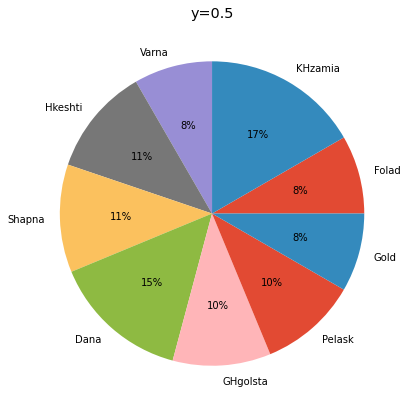

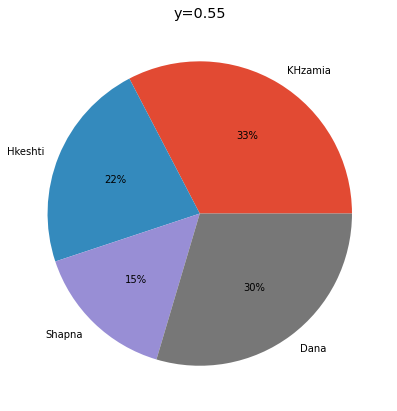

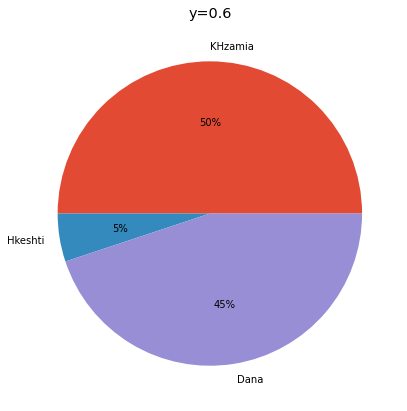

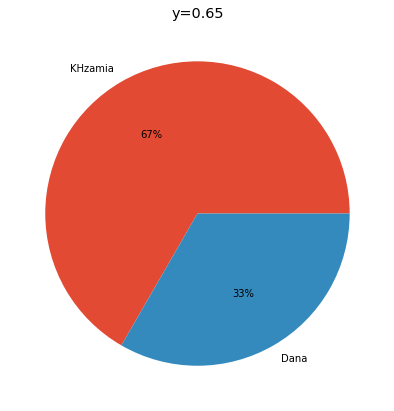

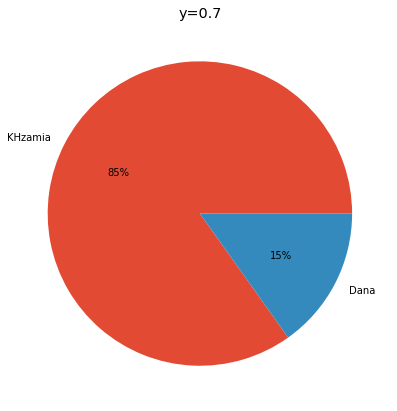

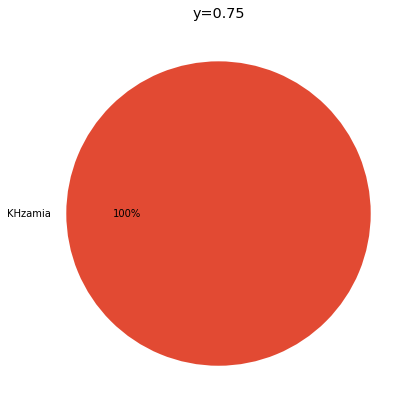

In [22]:
for y,row in prob_w.reindex(symbol_en).T.iterrows():
    pie_weight(row,title=f"y={np.round(y,2)}")
    if y >= 0.75:
        break

## Third approach for portfolio selection

3 diffrent kind of VaR is implemented:

   1. Historical
   
   2. parametric
   
   3.monte_carlo

In [23]:
var_historical = lambda symbol,df:round(pd.Series(df[symbol]).quantile(.05),2)
var_parametric = lambda symbol,df:round(df.mean()[symbol] + df.std()[symbol] * (-1.64),2)
def var_monte_carlo(symbol,df):
    var=0
    for j in range(1000):
        sample = np.random.normal(df.mean()[symbol],df.std()[symbol], len(symbols_monthly))
        var += round(np.quantile(sample,.05),5)
    return round(var/1000,2)

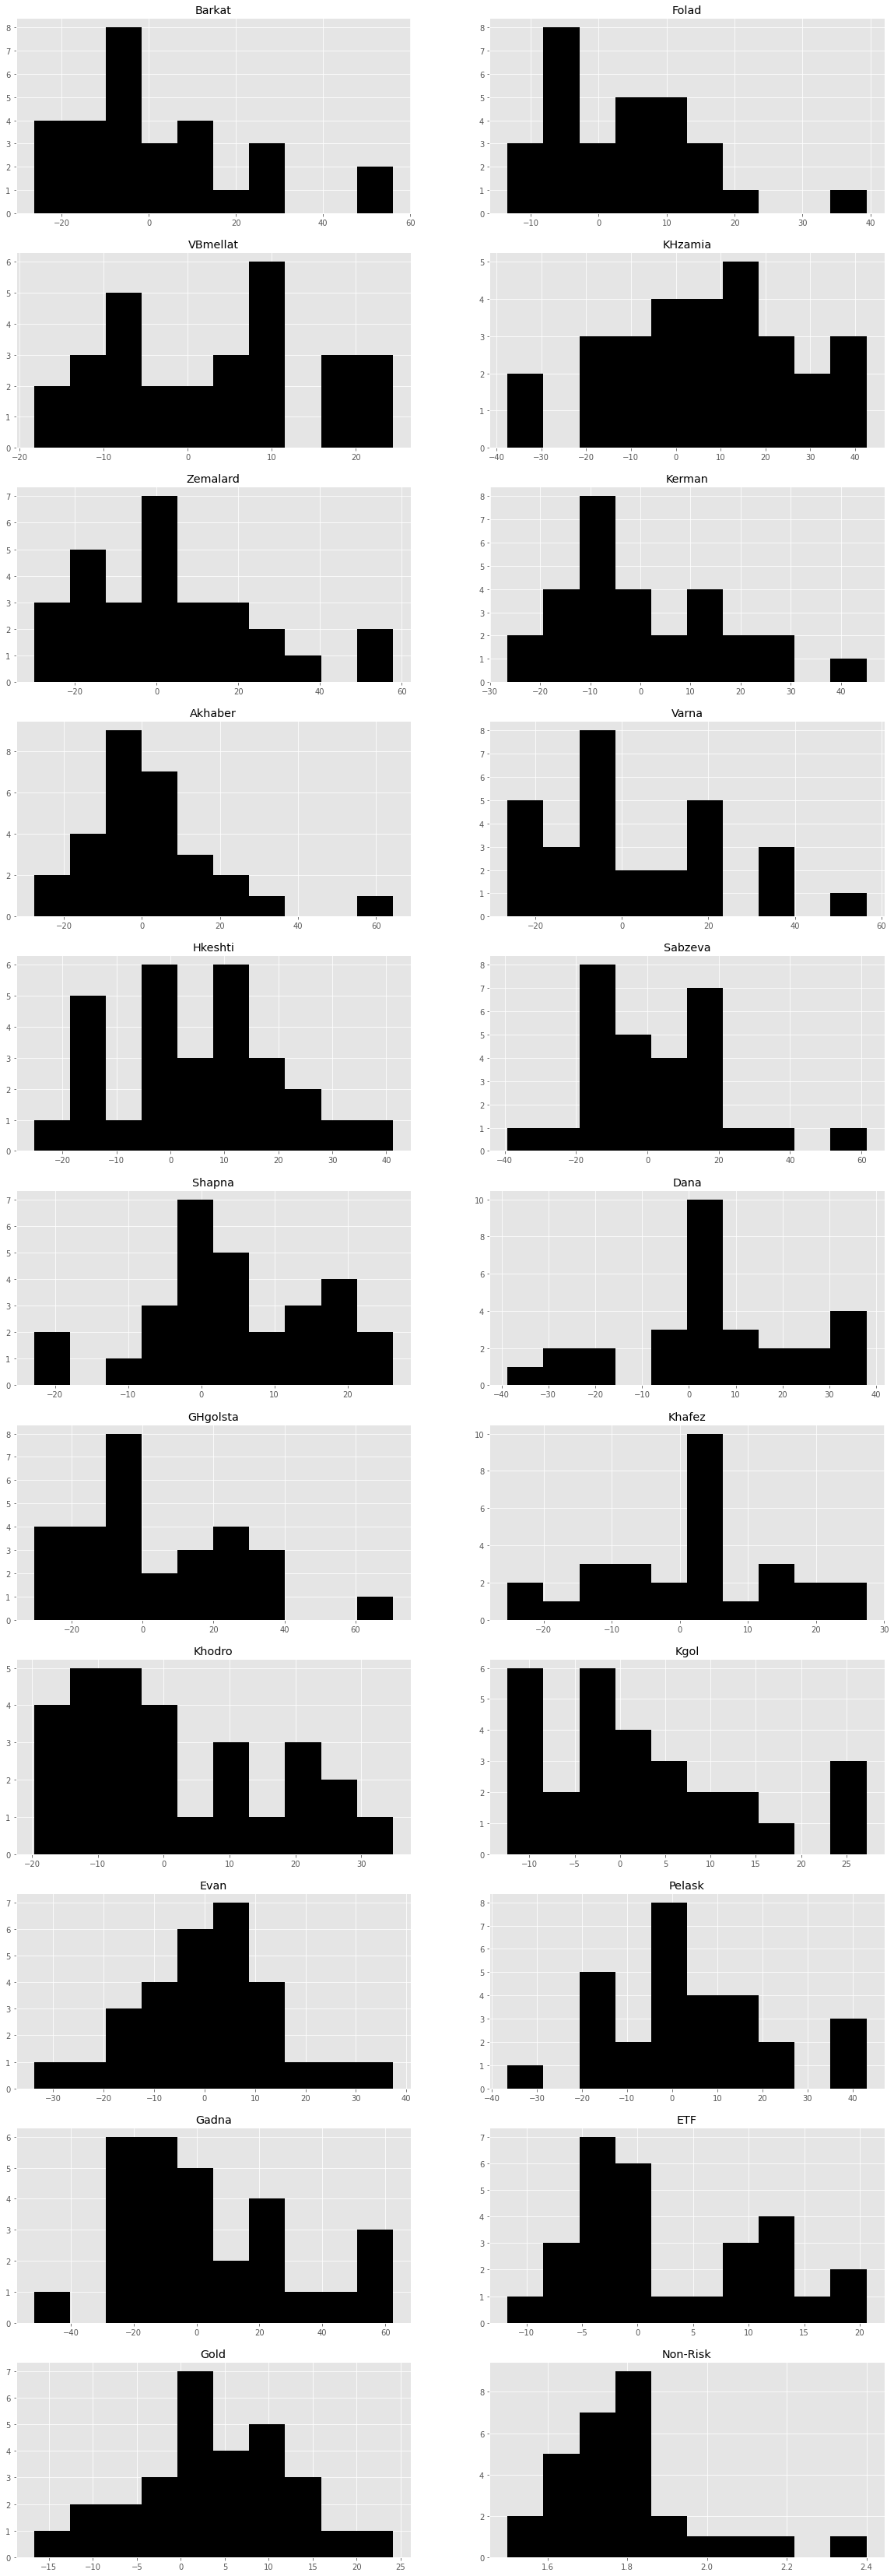

In [24]:
figure, axis = plt.subplots(11,2,figsize=(20, 60))
k=0
for i in range(11):
    for j in range(2):
        axis[i, j].hist(symbols_monthly[symbol_en[k]],color='black')
        axis[i,j].set_title(symbol_en[k])
        k+=1

In [25]:
symbol_var = {'symbol':[],'historical':[],'parametric':[],'monte_carlo':[]}
for symbol in symbol_en:
    symbol_var['symbol'].append(symbol)
    symbol_var['historical'].append(var_historical(symbol,symbols_monthly))
    symbol_var['parametric'].append(var_parametric(symbol,symbols_monthly))
    symbol_var['monte_carlo'].append(var_monte_carlo(symbol,symbols_monthly))
symbol_var_monthly = pd.DataFrame(symbol_var)
symbol_var_monthly

,symbol,historical,parametric,monte_carlo
0,Barkat,-23.08,-31.36,-28.42
1,Folad,-10.82,-15.57,-13.86
2,VBmellat,-15.28,-17.35,-15.51
3,KHzamia,-27.42,-26.48,-23.77
4,Zemalard,-24.84,-32.49,-29.48
5,Kerman,-21.08,-26.90,-23.93
6,Akhaber,-22.00,-28.55,-25.87
7,Varna,-25.02,-31.33,-28.39
8,Hkeshti,-16.84,-21.05,-18.78
9,Sabzeva,-18.90,-28.80,-25.84


In [26]:
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=False)
VaR_portfolio = risk*(-1.64)
VaR_portfolio

-11.901088725988084

In [27]:
def optimize_var(returns,symbol_var_monthly, target_ret=None):
    returns = returns.T.to_numpy()
    n, m = returns.shape
    weights = cp.Variable(n)
    sum_weights = cp.sum(weights)
    mu = returns.mean(axis=1)
    
    if target_ret is not None:
        target_return = cp.Parameter()
        target_return.value = target_ret
    
    # Here cov matrix is diffrent and is based on VaR
    var = np.array((symbol_var_monthly.set_index('symbol').monte_carlo)/-1)
    var = np.outer(var, var)
    cov_matrix = (np.array(symbols_monthly.corr())*var)
    
    risk = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(risk)
    
    limit_return = [weights.T@mu == target_return] if target_ret is not None else []
    short_avail = [weights >= 0]
    
    constraints = [sum_weights == 1]+short_avail+limit_return
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)
    
    Er = weights.value@mu
    
    return np.round(weights.value,2), np.sqrt(risk.value), np.round(Er,2)

So we improve VaR of portfo based on monte carlo approach

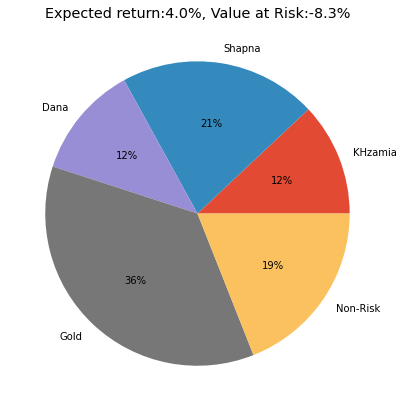

In [31]:
weights, risk, Er = optimize_var(symbols_monthly,symbol_var_monthly, target_ret=4)
pie_weight(weights, risk=None, Er=None, title=f'Expected return:{np.round(Er,1)}%, Value at Risk:{np.round(-risk,1)}%')

## Forth Approach for portfolio selection

In [4]:
symbols_close_monthly = pd.DataFrame()
for symbol in symbols:
    df = symbols_daily[symbol].copy()
    month = df.date.apply(lambda x: int(str(x).split()[0].replace('-',''))//100)
    df['month'] = month
    df = df.drop_duplicates('month',keep='first').reset_index(drop=True)
    df[symbol] = df.adjClose
    df = df.loc[:,['month',symbol]].set_index('month')
    symbols_close_monthly = pd.concat([symbols_close_monthly,df],axis=1)
symbols_close_monthly = symbols_close_monthly.fillna(method='ffill')
symbols_close_monthly.index = symbols_close_monthly.index.astype(str)
symbols_close_monthly.columns = symbol_en

Max Drawdown:64.3%


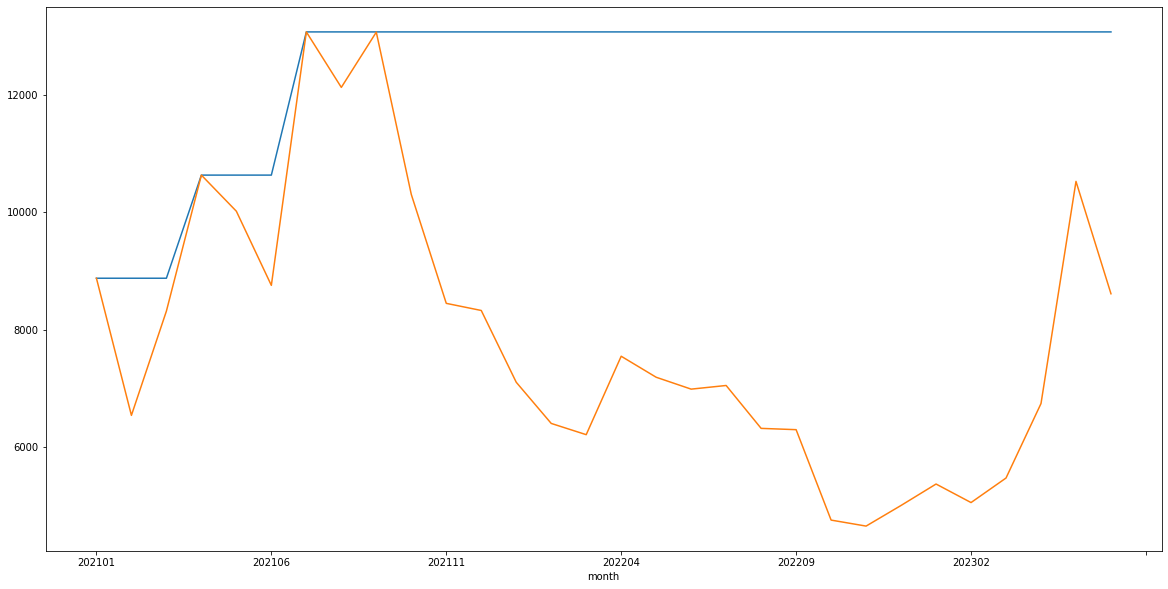

In [5]:
symbols_close_monthly.cummax()['Barkat'].plot(figsize=(20,10))
symbols_close_monthly['Barkat'].plot(figsize=(20,10))
dd = (symbols_close_monthly['Barkat'].cummax()-symbols_close_monthly['Barkat'])*100/symbols_close_monthly['Barkat'].cummax()
mdd = np.max(dd)
print(f"Max Drawdown:{np.round(mdd,2)}%")

In [6]:
def mmd_optimiziation(symbols_close_monthly,ret_target):
    # Define the objective function to minimize
    def objective_function(w):
        monthly_portfo_value = (symbols_close_monthly * w).sum(axis=1)
        return np.max((monthly_portfo_value.cummax()-monthly_portfo_value)*100/monthly_portfo_value.cummax())

    # Define the bounds for the weights (assuming they add up to 1)
    num_stocks = symbols_close_monthly.shape[1]
    bounds = [(0, 1) for i in range(num_stocks)]

    # Define the equality constraint that ensures the weights add up to 1
    def weight_constraint(w):
        return np.sum(w) - 1

    # Define the new constraint that the expected return of the portfolio be 2%
    def return_constraint(w):
        portfolio_return = sum(symbols_monthly.mean()*w)
        return portfolio_return - ret_target

    # Define the initial guess for the weights
    w0 = np.ones(num_stocks) / num_stocks

    # Run the optimization
    result = minimize(objective_function, w0, method='SLSQP',
                      bounds=bounds, constraints=[{'type': 'eq', 'fun': weight_constraint},
                        {'type': 'ineq', 'fun': return_constraint}])
    w,mdd = result.x, result.fun
    Er = return_constraint(w)+ret_target
    return w,Er,mdd

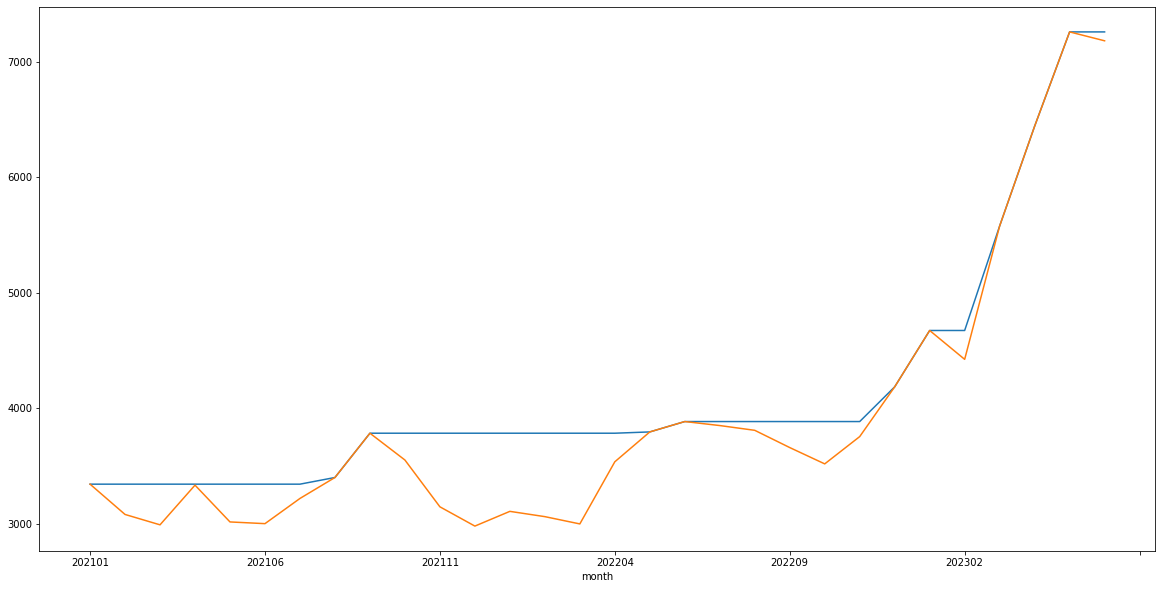

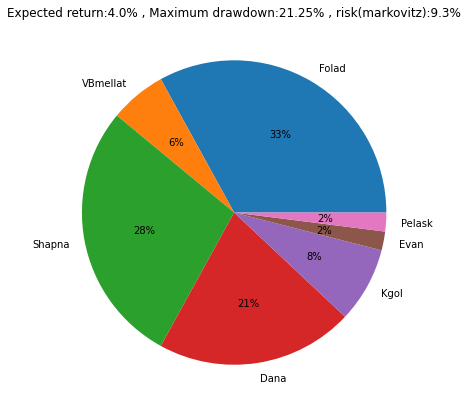

In [12]:
def portfo_drawdown(w):
    monthly_portfo_value = (symbols_close_monthly * w).sum(axis=1)
    monthly_portfo_value.cummax().plot(figsize=(20,10))
    monthly_portfo_value.plot(figsize=(20,10))
    return np.max((monthly_portfo_value.cummax()-monthly_portfo_value)*100/monthly_portfo_value.cummax())
weights, risk, Er = optimize_portfolio(symbols_monthly,target_ret=4,short_sell=False)
dd = portfo_drawdown(weights)
pie_weight(weights,title=f"Expected return:{np.round(Er,2)}% , Maximum drawdown:{np.round(dd,2)}% , "+
          f"risk(markovitz):{np.round(risk,2)}%")

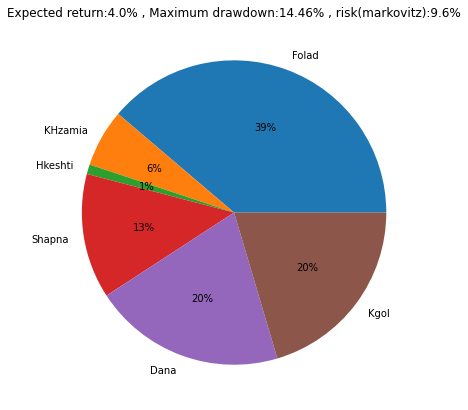

In [11]:
w,Er,mdd = mmd_optimiziation(symbols_close_monthly,4)
pie_weight(w,title=f"Expected return:{np.round(Er,2)}% , Maximum drawdown:{np.round(mdd,2)}% , "+
          f"risk(markovitz):{np.round(np.sqrt((w@np.cov(symbols_monthly.T)@w.T)),2)}%")